In [1]:
import os.path as osp
import argparse

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv,GATConv  # noqa
from torch_geometric.utils import negative_sampling
from torch_geometric.data import NeighborSampler

dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

x = data.x
y = data.y.squeeze()


Processing...
Done!


In [2]:
class Net(torch.nn.Module):
    def __init__(self,mode='UNSUP',conv='GCN'):
        super(Net, self).__init__()
        self.mode = mode
        self.conv=conv
        self.num_layers = 2
        
        self.convs = torch.nn.ModuleList()
    
        if self.mode=='UNSUP':
            out_channels = 128
        elif self.mode=='SUP':
            out_channels = dataset.num_classes
        
        if self.conv == 'GCN':
            self.convs.append(GCNConv(dataset.num_features, 260))
            self.convs.append(GCNConv(260, out_channels))
        if self.conv == 'SAGE':
            self.convs.append(SAGEConv(dataset.num_features, 260))
            self.convs.append(SAGEConv(260, out_channels))
        if self.conv == 'GAT':
            self.convs.append(GATConv(dataset.num_features, 260))
            self.convs.append(GATConv(260, out_channels))
                
    def forward(self,x,data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.convs[0](x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = self.convs[1](x, edge_index, edge_weight)
        if self.mode=='UNSUP':
            return x
        elif self.mode=='SUP':
            return x.log_softmax(dim=-1)
        
    def loss_SAGE(self,out,pos_edge_index):
        pos_loss = 0 
        for i in range(len(pos_edge_index[0])):
            pos_loss -= torch.log(torch.sigmoid(torch.dot(out[pos_edge_index[0][i]],out[pos_edge_index[1][i]])))
        pos_loss = pos_loss/len(pos_edge_index[0])
        
        ##negative sampling
        neg_edge_index = negative_sampling(torch.Tensor(pos_edge_index), out[data.train_mask].size(0))
        neg_edge_index = neg_edge_index.tolist()
        neg_loss = 0 
        for i in range(len(neg_edge_index[0])):
            neg_loss -= torch.log(torch.sigmoid((-1)*torch.dot(out[neg_edge_index[0][i]],out[neg_edge_index[1][i]])))
        neg_loss = neg_loss/len(neg_edge_index[0])
        
        return pos_loss + neg_loss
    
    ##loss function for supervised     
    def loss_sup(self, pred, label):
        return F.nll_loss(pred, label)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =data.to(device)


In [3]:
##positive samples for training set

l = torch.Tensor(list(range(len(x))))
data.train_mask.tolist()
l[data.train_mask.tolist()]
pos_index = [[],[]]
for i,ind in enumerate(data.edge_index[0]):
    if ind in l[data.train_mask.tolist()]:
        if data.edge_index[1][i] in l[data.train_mask.tolist()]:
            pos_index[0].append(ind)
            pos_index[1].append(data.edge_index[1][i])
 

In [15]:
#UNSUPERVISED
model = Net(mode='UNSUP',conv='SAGE').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 

def train():
    model.train()
    optimizer.zero_grad()
    out = model(x, data)
    loss = model.loss_SAGE(out,pos_index)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test():
    model.eval()
    out = model.forward(x,data)
    y_true = y.cpu().unsqueeze(-1)
    
    clf = MLPClassifier(random_state=1, max_iter=1000).fit(out.detach().numpy(),y.detach().numpy())
    
    y_pred = clf.predict(out.detach().numpy())
    
    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:    
        results += [clf.score(out.detach().numpy()[mask], y.detach()[mask].numpy())]
    return results

In [16]:
losses=[]
for epoch in range(1, 40):
    loss = train()
    losses.append(loss)
    train_acc, val_acc, test_acc = test()
    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(loss, epoch, train_acc, val_acc, test_acc))

Loss: 1.3985, Epoch: 001, Train: 0.6071, Val: 0.6700, Test: 0.6710
Loss: 1.3932, Epoch: 002, Train: 0.6500, Val: 0.6900, Test: 0.6960
Loss: 1.3874, Epoch: 003, Train: 0.6571, Val: 0.6860, Test: 0.6940
Loss: 1.3844, Epoch: 004, Train: 0.7357, Val: 0.7140, Test: 0.7350
Loss: 1.3818, Epoch: 005, Train: 0.7500, Val: 0.7420, Test: 0.7450
Loss: 1.3775, Epoch: 006, Train: 0.7429, Val: 0.7520, Test: 0.7610
Loss: 1.3726, Epoch: 007, Train: 0.7500, Val: 0.7480, Test: 0.7700
Loss: 1.3693, Epoch: 008, Train: 0.7500, Val: 0.7560, Test: 0.7740
Loss: 1.3642, Epoch: 009, Train: 0.7571, Val: 0.7540, Test: 0.7710
Loss: 1.3605, Epoch: 010, Train: 0.7571, Val: 0.7580, Test: 0.7740


/home/anpolol/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Loss: 1.3515, Epoch: 011, Train: 0.7571, Val: 0.7580, Test: 0.7810
Loss: 1.3419, Epoch: 012, Train: 0.7643, Val: 0.7500, Test: 0.7800


/home/anpolol/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Loss: 1.3348, Epoch: 013, Train: 0.7571, Val: 0.7760, Test: 0.7750
Loss: 1.3215, Epoch: 014, Train: 0.7571, Val: 0.7520, Test: 0.7660
Loss: 1.2963, Epoch: 015, Train: 0.7357, Val: 0.7380, Test: 0.7570
Loss: 1.2967, Epoch: 016, Train: 0.7286, Val: 0.7380, Test: 0.7500
Loss: 1.2615, Epoch: 017, Train: 0.7500, Val: 0.7460, Test: 0.7610
Loss: 1.2350, Epoch: 018, Train: 0.7357, Val: 0.7580, Test: 0.7520
Loss: 1.2178, Epoch: 019, Train: 0.7500, Val: 0.7580, Test: 0.7630
Loss: 1.1672, Epoch: 020, Train: 0.7357, Val: 0.7560, Test: 0.7540
Loss: 1.1626, Epoch: 021, Train: 0.7500, Val: 0.7600, Test: 0.7650
Loss: 1.0883, Epoch: 022, Train: 0.7571, Val: 0.7600, Test: 0.7680
Loss: 1.0620, Epoch: 023, Train: 0.7429, Val: 0.7620, Test: 0.7730
Loss: 1.0432, Epoch: 024, Train: 0.7643, Val: 0.7640, Test: 0.7790
Loss: 0.9709, Epoch: 025, Train: 0.7643, Val: 0.7600, Test: 0.7830
Loss: 0.9096, Epoch: 026, Train: 0.7714, Val: 0.7580, Test: 0.7880
Loss: 0.8961, Epoch: 027, Train: 0.7714, Val: 0.7600, Test: 0.

In [21]:
#SUPERVISED

model = Net(mode='SUP',conv='GAT').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_sup():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(x,data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss
@torch.no_grad()
def test_sup():
    model.eval()
    logits,accs = model.forward(x,data),[]
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losses_sup=[]
best_val_acc = test_acc = 0
for epoch in range(1, 20):
    loss = train_sup()
    losses_sup.append(loss)
    train_acc, val_acc, tmp_test_acc = test_sup()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(loss, epoch, train_acc, best_val_acc, test_acc))

Loss: 1.9460, Epoch: 001, Train: 0.8071, Val: 0.5600, Test: 0.5290
Loss: 1.9165, Epoch: 002, Train: 0.9571, Val: 0.7740, Test: 0.7740
Loss: 1.8804, Epoch: 003, Train: 0.9714, Val: 0.7740, Test: 0.7740
Loss: 1.8241, Epoch: 004, Train: 0.9643, Val: 0.7740, Test: 0.7740
Loss: 1.7572, Epoch: 005, Train: 0.9571, Val: 0.7740, Test: 0.7740
Loss: 1.6852, Epoch: 006, Train: 0.9571, Val: 0.7740, Test: 0.7740
Loss: 1.5979, Epoch: 007, Train: 0.9571, Val: 0.7740, Test: 0.7740
Loss: 1.5096, Epoch: 008, Train: 0.9714, Val: 0.7760, Test: 0.7750
Loss: 1.4100, Epoch: 009, Train: 0.9714, Val: 0.7900, Test: 0.7890
Loss: 1.3043, Epoch: 010, Train: 0.9714, Val: 0.8060, Test: 0.7910
Loss: 1.1887, Epoch: 011, Train: 0.9714, Val: 0.8080, Test: 0.7940
Loss: 1.0696, Epoch: 012, Train: 0.9786, Val: 0.8080, Test: 0.7940
Loss: 0.9440, Epoch: 013, Train: 0.9786, Val: 0.8080, Test: 0.7940
Loss: 0.8258, Epoch: 014, Train: 0.9786, Val: 0.8080, Test: 0.7940
Loss: 0.7069, Epoch: 015, Train: 0.9786, Val: 0.8080, Test: 0.

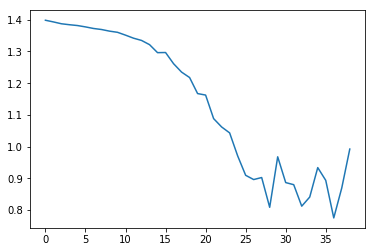

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses)

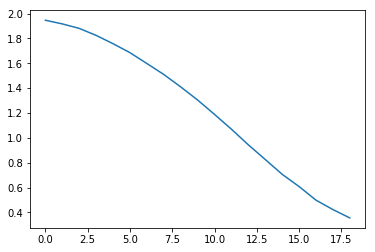

In [22]:
plt.plot(losses_sup)